In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from xgboost import plot_importance
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation 
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_style("whitegrid")
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False
#加载数据集
import warnings 
warnings.filterwarnings("ignore") 
iris=sns.load_dataset("iris")
iris.head()
# & Sepal.Length（花萼长度），单位是cm;
# & Sepal.Width（花萼宽度），单位是cm;
# & Petal.Length（花瓣长度），单位是cm;
# & Petal.Width（花瓣宽度），单位是cm;
# Iris Setosa（山鸢尾）、Iris Versicolour（杂色鸢尾），以及Iris Virginica（维吉尼亚鸢尾）。

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

# 数据可视化
---
寻找两两属性之间的相关性

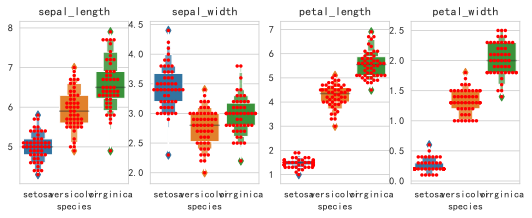

In [2]:
fig, axs = plt.subplots(1, 4, figsize=(9,3))
for i in range(4):
    sns.boxenplot(x="species", y=iris.columns[i], data=iris, ax = axs[i])
    sns.swarmplot(x="species", y=iris.columns[i], data=iris, ax = axs[i],size = 3.5, color="red")
    axs[i].set_title(iris.columns[i])
    axs[i].set_ylabel('')


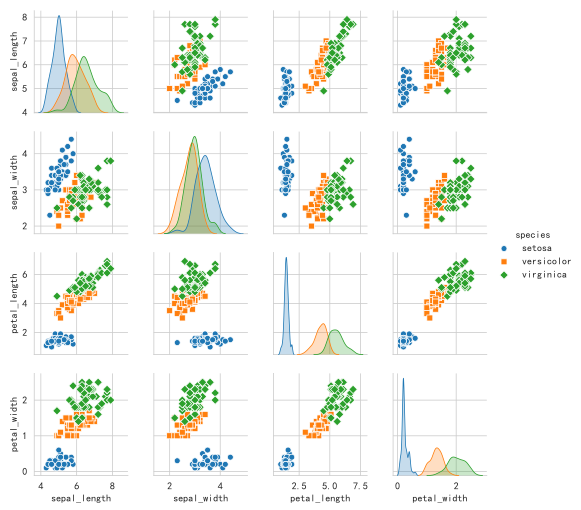

In [3]:
# 多变量图
g = sns.pairplot(data=iris, diag_kind="kde",diag_kws=dict(linewidth = 0.8),
                 hue='species', markers=["o", "s", "D"],height =1.8)

数据处理  (one-hot编码)

In [4]:
dummies_iris = pd.get_dummies(iris['species'], prefix= 'species')
iris_df = pd.concat([iris, dummies_iris], axis=1)
iris_df.describe()

sepal_length  sepal_width  petal_length  petal_width  species_setosa  \
count    150.000000   150.000000    150.000000   150.000000      150.000000   
mean       5.843333     3.057333      3.758000     1.199333        0.333333   
std        0.828066     0.435866      1.765298     0.762238        0.472984   
min        4.300000     2.000000      1.000000     0.100000        0.000000   
25%        5.100000     2.800000      1.600000     0.300000        0.000000   
50%        5.800000     3.000000      4.350000     1.300000        0.000000   
75%        6.400000     3.300000      5.100000     1.800000        1.000000   
max        7.900000     4.400000      6.900000     2.500000        1.000000   

       species_versicolor  species_virginica  
count          150.000000         150.000000  
mean             0.333333           0.333333  
std              0.472984           0.472984  
min              0.000000           0.000000  
25%              0.000000           0.000000  
50%              0.000000           0.000000  
75%              1.000000           1.000000  
max              1.000000           1.000000

# 模型建立与求解


In [5]:
#sigmoid函数
def sigmoid(X):
    return 1/(1+np.exp(-X))

# 预测
def predict(X_train,w):
    return sigmoid( X_train * w )

# 获取准确率
def predict_acc(X_train,X_test,y_train,y_test,w):
    
    if(y_test.shape[1]==3):#多分类问题时
        train_pred = np.argmax(predict(X_train,w), axis=1)
        test_pred = np.argmax(predict(X_test,w), axis=1)
        y_train = np.argmax(y_train, axis=1)
        y_test = np.argmax(y_test, axis=1)
    else:
        train_pred = np.round(predict(X_train,w))
        test_pred = np.round(predict(X_test,w))
        
    acc_train = metrics.accuracy_score(y_train, train_pred)
    acc_test = metrics.accuracy_score(y_test, test_pred)
    return acc_train,acc_test

# 获取损失函数值
def predict_error(X_train,X_test,y_train,y_test,w):
    train_pred = predict(X_train,w)
    test_pred = predict(X_test,w)
    error_train = 0.5*np.sum(np.multiply(train_pred-y_train,train_pred-y_train))/len(X_train)
    error_test = 0.5*np.sum(np.multiply(test_pred-y_test,test_pred-y_test))/len(X_test)
    return error_train,error_test

#梯度下降法
def gra_ascent_train( X ,y,alpha=0.01,epoch=100, test_size = 0.3,random_state= 1111, attenuation = 0.9):
    
    X_train,X_test,y_train,y_test = train_test_split(
        X ,y, test_size=test_size, random_state = random_state)
    
    w = np.ones((epoch+1,X_train.shape[1],y_train.shape[1]))
    error_train = np.ones((epoch,))
    error_test = np.ones((epoch,))
    accuracy_train = np.ones((epoch,))
    accuracy_test = np.ones((epoch,))
#     进行训练
    for i in range(epoch):
        alpha=alpha * attenuation
        error_train[i],error_test[i] = predict_error(X_train,X_test,y_train,y_test,np.mat(w[i,:,:]))
        accuracy_train[i],accuracy_test[i] = predict_acc(X_train,X_test,y_train,y_test,np.mat(w[i,:,:]))
        error = predict(X_train,np.mat(w[i,:,:])) - y_train
        w[i+1,:,:] = w[i,:,:] - alpha * X_train.transpose() * error
        
    return w,error_train,error_test,accuracy_train,accuracy_test

 

In [6]:
# 绘图所需
def draw_acc_erro(axs,error_train,error_test,accuracy_train,accuracy_test,i ):

      
    axs[0,i].plot(range(len(error_test)),error_test,'r-',
                  range(len(error_train)),error_train,'g-',linewidth=2.2,alpha=0.7)
    axs[0,i].set_title("测试集大小:{0:.1f}".format(test_sizei))
    
    axs[1,i].plot(range(len(accuracy_test)),accuracy_test,'r-',
                  range(len(accuracy_train)),accuracy_train,'g-',linewidth=2.2,alpha=0.7)
    axs[1,i].set_xlabel("迭代次数")
    if i>1:
        axs[0,i].legend(['Test set','Train set'])
    if i<1:
        axs[0,i].set_ylabel("损失函数值")
        axs[1,i].set_ylabel("准确率")

### 二分类问题
---
以是否为Iris Setosa（山鸢尾）为标签, 是为1，不是为0.


test_size:0.1|  accuracy_score_train: 1.000  accuracy_score_test:1.000
test_size:0.3|  accuracy_score_train: 1.000  accuracy_score_test:1.000
test_size:0.5|  accuracy_score_train: 1.000  accuracy_score_test:1.000


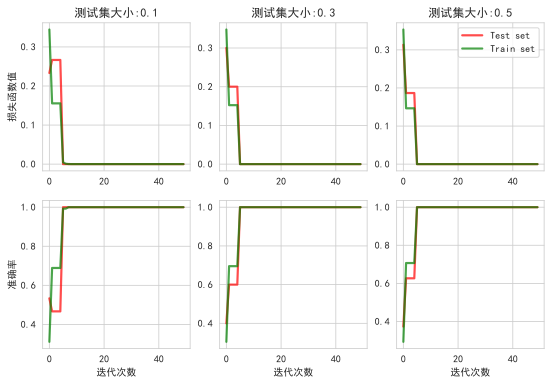

In [7]:
y =iris_df.iloc[:,5:6]
X =iris_df.iloc[:,:4]
X['b'] = 1
fig, axs = plt.subplots(2, 3, figsize=(9,6))
fig.set(alpha=0.2)  # 设定图表颜色alpha参数
# 模型求解
for i,test_sizei in enumerate([0.1,0.3,0.5]):

    w,error_train,error_test,accuracy_train,accuracy_test = gra_ascent_train(
        np.mat(X) ,np.mat(y),alpha=0.1,epoch=50,test_size = test_sizei,random_state= 1412, attenuation =0.9)

    print("test_size:{0:.1f}|  accuracy_score_train: {1:.3f}  accuracy_score_test:{2:.3f}".format(
                 test_sizei,accuracy_train[-1:][0],accuracy_test[-1:][0]))
    draw_acc_erro(axs,error_train,error_test,accuracy_train,accuracy_test ,i)

### 多分类问题
---
采取所有种类进行多分类训练：

Iris Setosa（山鸢尾：100）、Iris Versicolour（杂色鸢尾：010），Iris Virginica（维吉尼亚鸢尾：001）


test_size:0.1|  accuracy_score_train: 0.963  accuracy_score_test:1.000
test_size:0.3|  accuracy_score_train: 0.962  accuracy_score_test:0.978
test_size:0.5|  accuracy_score_train: 0.947  accuracy_score_test:0.987


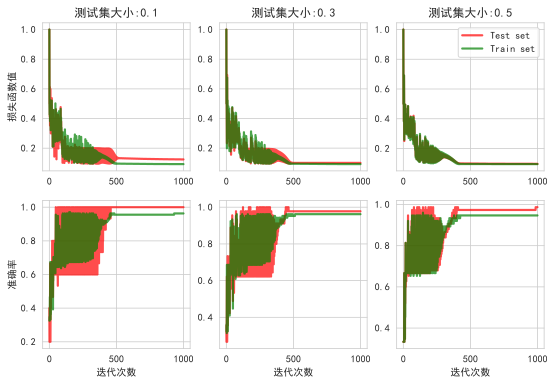

In [8]:
y =iris_df.iloc[:,5:]
X =iris_df.iloc[:,:4]
X['b'] = 1
fig, axs = plt.subplots(2, 3, figsize=(9,6))
# 模型求解
for i,test_sizei in enumerate([0.1,0.3,0.5]):

    w,error_train,error_test,accuracy_train,accuracy_test = gra_ascent_train( np.mat(X) ,np.mat(y),
                 alpha=0.01,epoch=1000,test_size = test_sizei,random_state= 1234, attenuation =0.997)

    print("test_size:{0:.1f}|  accuracy_score_train: {1:.3f}  accuracy_score_test:{2:.3f}".format(
                 test_sizei,accuracy_train[-1:][0],accuracy_test[-1:][0]))
    draw_acc_erro(axs,error_train,error_test,accuracy_train,accuracy_test,i )

# xgboost
---
寻找影响较大的属性，进行降维

accuracy_score_train: 1.000  accuracy_score_test:0.956


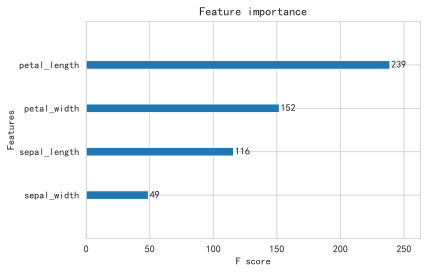

In [9]:
#对类型进行重编码
xg_iris_df = iris.copy()
xg_iris_df['species_Code'] = LabelEncoder().fit_transform(iris['species'])
xg_iris_df.drop(['species'], axis=1, inplace=True)
xg_y =xg_iris_df.iloc[:,-1:]
xg_X =xg_iris_df.iloc[:,:4]
# xg_y = xg_y.values.reshape(len(xg_y),)
# xg_X = xg_X.values.reshape(len(xg_X),4)
X_train,X_test,y_train,y_test = train_test_split(
    xg_X ,xg_y, test_size=0.3, random_state= 1111)
# 进行训练
model = XGBClassifier().fit(X_train, y_train)

train_pred = model.predict( X_train )
test_pred = model.predict( X_test )
print("accuracy_score_train: {0:.3f}  accuracy_score_test:{1:.3f}".format(
    metrics.accuracy_score(y_train, train_pred),
    metrics.accuracy_score(y_test, test_pred) ))
#画出重要性图
plot_importance(model)

In [10]:
# 选择特征,,特征与正确率的关系
model = XGBClassifier()
model.fit(X_train, y_train)
feat_imp = dict(zip(model.get_booster().feature_names,model.feature_importances_))
feat_imp = sorted(feat_imp.items(), key=lambda e:e[1], reverse=True)

print(feat_imp)
for name,thresh in  feat_imp:
#     选择不同特征
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
#     训练模型
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    
    train_pred = selection_model.predict( select_X_train )
    test_pred = selection_model.predict( select_X_test )
    train_accuracy = metrics.accuracy_score(y_train, train_pred)
    test_accuracy = metrics.accuracy_score(y_test, test_pred)
    print("Thresh={0:.3f}, n={1:}, accuracy_score_train: {2:.3f}, accuracy_score_test:{3:.3f},  ".format(
        thresh, select_X_train.shape[1],train_accuracy,test_accuracy) +  name)

[('petal_length', 0.42985612), ('petal_width', 0.2733813), ('sepal_length', 0.2086331), ('sepal_width', 0.0881295)]
Thresh=0.430, n=1, accuracy_score_train: 0.962, accuracy_score_test:0.933,  petal_length
Thresh=0.273, n=2, accuracy_score_train: 1.000, accuracy_score_test:0.956,  petal_width
Thresh=0.209, n=3, accuracy_score_train: 1.000, accuracy_score_test:0.956,  sepal_length
Thresh=0.088, n=4, accuracy_score_train: 1.000, accuracy_score_test:0.956,  sepal_width


# 模型可视化
---
进行了重编码

Iris Setosa（山鸢尾：00）、Iris Versicolour（杂色鸢尾：01），Iris Virginica（维吉尼亚鸢尾：11）

In [11]:
# 划分数据集，训练模型
y_vi = iris.iloc[:,0:0]
X_vi =iris.iloc[:,2:4]
X_vi['b'] = 1
y_vi['species_bin1'] =  iris['species'].apply(lambda x: int(x == 'virginica'))
y_vi['species_bin2'] =  iris['species'].apply(lambda x: int(x != 'setosa'))

# 模型求解
w,error_train,error_test,accuracy_train,accuracy_test = gra_ascent_train( np.mat(X_vi) ,np.mat(y_vi),
            alpha=0.1,epoch=1500,test_size = 0.3,random_state= 1234, attenuation =0.999)
    
accuracy_train[-1:][0],accuracy_test[-1:][0]

(0.9619047619047619, 0.9555555555555556)

In [12]:
%matplotlib 

Using matplotlib backend: Qt5Agg


In [13]:
# 模型的动态可视化
%matplotlib 
def line_yi(w_plot,xi,i):
    return (xi * w_plot[0,0,i] + w_plot[0,2,i]) /(-w_plot[0,1,i])


fig, axs = plt.subplots(1, 2, figsize=(10,4))
fig.set(alpha=0.2)  # 设定图表颜色alpha参数
sns.scatterplot(x="petal_length", y="petal_width", hue="species",palette=["b", "r","g"],
            data=iris,ax=axs[1]) 

xi = np.linspace(0, 8, 10)
w_plot = w[100:100+1,:,:]
line1,line2, = axs[1].plot(xi, line_yi(w_plot,xi,0),'r-' ,xi,line_yi(w_plot,xi,1),'r-', linewidth=2)

line3,line4, = axs[0].plot(range(0,len(error_test[:0]),1),error_test[:0], 'r-',
                     range(0,len(error_train[:0]),1), error_train[:0], 'g-',linewidth=1.2,alpha = 0.7)
axs[0].legend(['测试集','训练集'])
axs[0].set_ylabel("损失函数值")
axs[0].set_xlabel("迭代次数")
axs[0].set_ylim([0,np.max(error_test)*1.2])
axs[0].set_xlim([0,len(error_test)])
axs[1].set_ylim([-1,5])
anno0 = axs[0].annotate("训练集损失函数值{0:.3f}".format(error_train[0]), xy=(100,error_train[100]),
                        xytext=(len(error_train)*0.58,np.max(error_test)*0.8),
                        arrowprops=dict(facecolor='g', shrink=0.05))

anno1 = axs[0].annotate("测试集损失函数值{0:.3f}".format(error_test[0]),  xy=(100,error_test[100]),
                        xytext=(len(error_test)*0.58,np.max(error_test)*0.72),
                        arrowprops=dict(facecolor='r', shrink=0.05))
plt.suptitle("测试集大小:{0:.1f}".format(0.3))
def update(i):
    w_plot = w[i:i+1,:,:]
    line1.set_ydata(line_yi(w_plot,xi,0))
    line2.set_ydata(line_yi(w_plot,xi,1))
    line3.set_data(range(0,len(error_test[:i]),1),error_test[:i])
    line4.set_data(range(0,len(error_train[:i]),1),error_train[:i])
    
    anno0.xy = [i,error_train[i]]
    anno1.xy = [i,error_test[i]]
    anno0.set_text("训练集损失函数值{0:.3f}".format(error_train[i]))
    anno1.set_text("测试集损失函数值{0:.3f}".format(error_test[i]))
    return line1,line2,line3,line4,anno1,anno0
    
ani = FuncAnimation(fig, update,frames = np.arange(0, len(error_test),10),interval=0)

Using matplotlib backend: Qt5Agg


效果如下   (详情见附件demo.gif)：

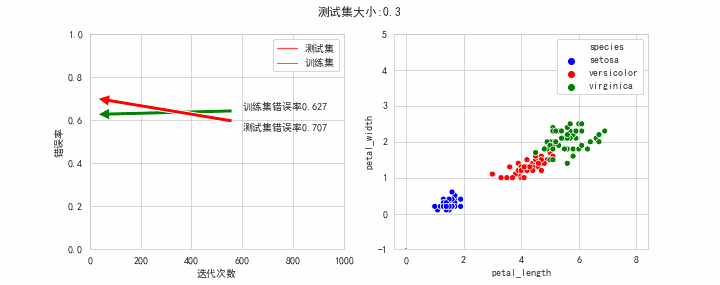


In [14]:
%matplotlib inline  

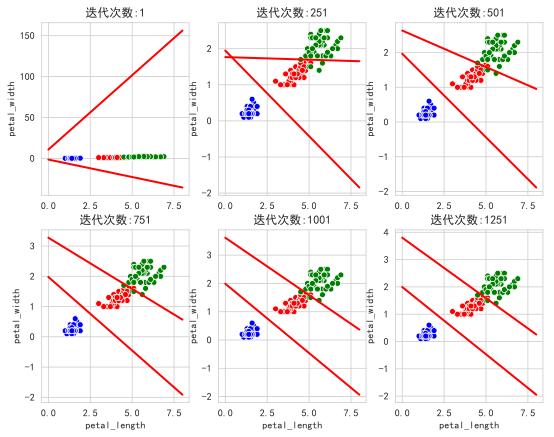

In [15]:
# 模型可视化静态描述

fig, axs = plt.subplots(2, 3, figsize=(9,7))
epoch = np.arange(1, len(error_test),round(len(error_test)/6))
for i,epochi in enumerate(epoch):
    sns.scatterplot(x="petal_length", y="petal_width", hue="species",palette=["b", "r","g"],
                data=iris,ax=axs[int(np.floor(i/3)),np.mod(i,3)],legend  = False)
    xi = np.linspace(0, 8, 10) 
    w_plot = w[epochi:epochi+1,:,:]
    axi = i//3
    axj = np.mod(i,3)
    axs[axi,axj].plot(xi, line_yi(w_plot,xi,0), 'r-', linewidth=2)
    axs[axi,axj].plot(xi, line_yi(w_plot,xi,1), 'r-', linewidth=2)
    axs[axi,axj].set_title("迭代次数:{0:}".format(epochi))
    if axi==0:
        axs[axi,axj].set_xlabel("")

test_size:0.1|  accuracy_score_train: 0.956  accuracy_score_test:1.000
test_size:0.3|  accuracy_score_train: 0.952  accuracy_score_test:0.956
test_size:0.5|  accuracy_score_train: 0.973  accuracy_score_test:0.960


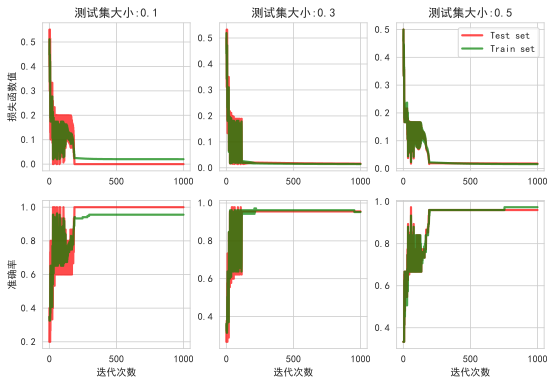

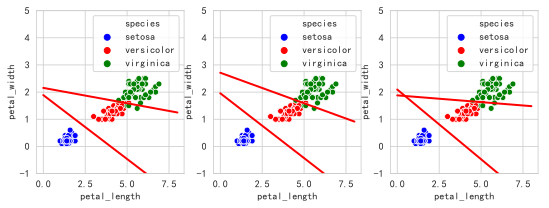

In [24]:
# 最终结果
fig, axs = plt.subplots(2, 3, figsize=(9,6))
fig, axs2 = plt.subplots(1, 3, figsize=(9,3))
# 模型求解
for i,test_sizei in enumerate([0.1,0.3,0.5]):

    w,error_train,error_test,accuracy_train,accuracy_test = gra_ascent_train( np.mat(X_vi) ,np.mat(y_vi),
                 alpha=0.1,epoch=1000,test_size = test_sizei,random_state= 1234, attenuation =0.997)

    print("test_size:{0:.1f}|  accuracy_score_train: {1:.3f}  accuracy_score_test:{2:.3f}".format(
                 test_sizei,accuracy_train[-1:][0],accuracy_test[-1:][0]))
    draw_acc_erro(axs,error_train,error_test,accuracy_train,accuracy_test,i )
    
    
    sns.scatterplot(x="petal_length", y="petal_width", hue="species",palette=["b", "r","g"],
                data=pd.concat([X,iris_df.species],axis=1),ax=axs2[i])
    
    xi = np.linspace(0, 8, 10) 
    w_plot = w[-1:,:,:]
    axs2[i].plot(xi,line_yi(w_plot,xi,0), 'r-', linewidth=2)
    axs2[i].plot(xi,line_yi(w_plot,xi,1), 'r-', linewidth=2)
    
    axs2[i].set_ylim([-1,5])